In [14]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt
from math import ceil, sqrt
from distfit import distfit
from tqdm import tqdm

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

def scott_rule(data):
  std = np.std(data, ddof=1)
  n = len(data)
  return std * n**(-1/5)


# Projekt 3 - AMA & 
### Komosa Maciej, 3 rok IiE (S)

In [15]:
data = pd.read_csv('plik7.csv')
data.drop('Unnamed: 0', axis=1, inplace=True)

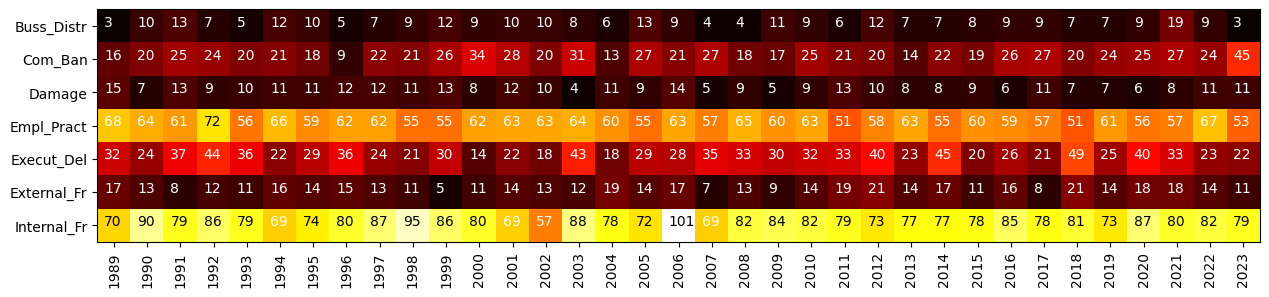

In [16]:
categories = set(data['linia'])
years = set(data['rok'])

frequency_table = data.groupby(['linia', 'rok']).size().unstack(fill_value=0)

plt.figure(figsize=(15, 25))
plt.imshow(frequency_table, cmap='hot', interpolation='nearest')
for a, j in enumerate(frequency_table.index):
    for i, k in enumerate(frequency_table.columns):
        plt.text(i-0.3, a, frequency_table.loc[j, k], color='white' if frequency_table.loc[j, k] < 70 else 'black')
plt.xticks(ticks=range(len(frequency_table.columns)), labels=frequency_table.columns, rotation=90)
plt.yticks(ticks=range(len(frequency_table.index)), labels=frequency_table.index)
plt.show()

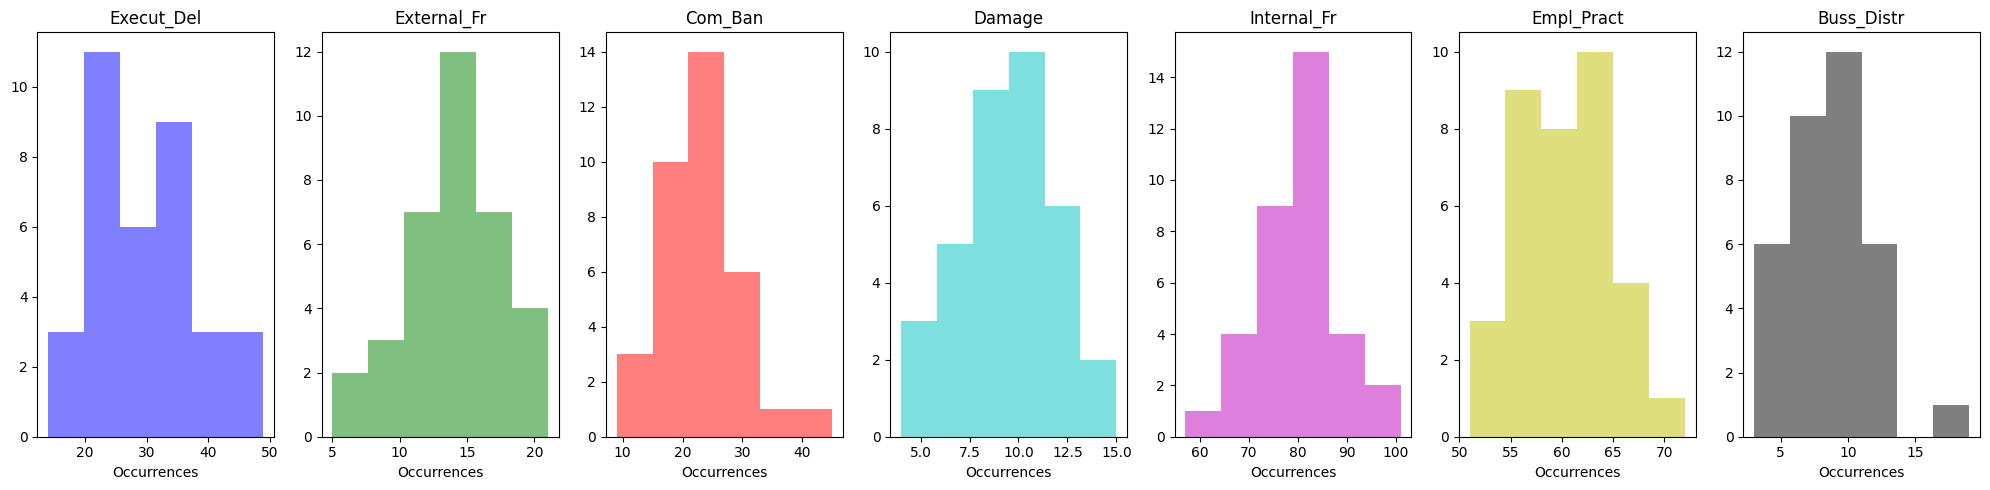

In [17]:
fig, axes = plt.subplots(ncols=len(categories), figsize=(20, 5))

for i, category in enumerate(categories):
    axes[i].hist(frequency_table.loc[category], color=colors[i], bins=ceil(sqrt(len(frequency_table.loc[category]))), alpha=0.5)
    axes[i].set_title(category)
    axes[i].set_xlabel('Occurrences')

plt.tight_layout()
plt.show()

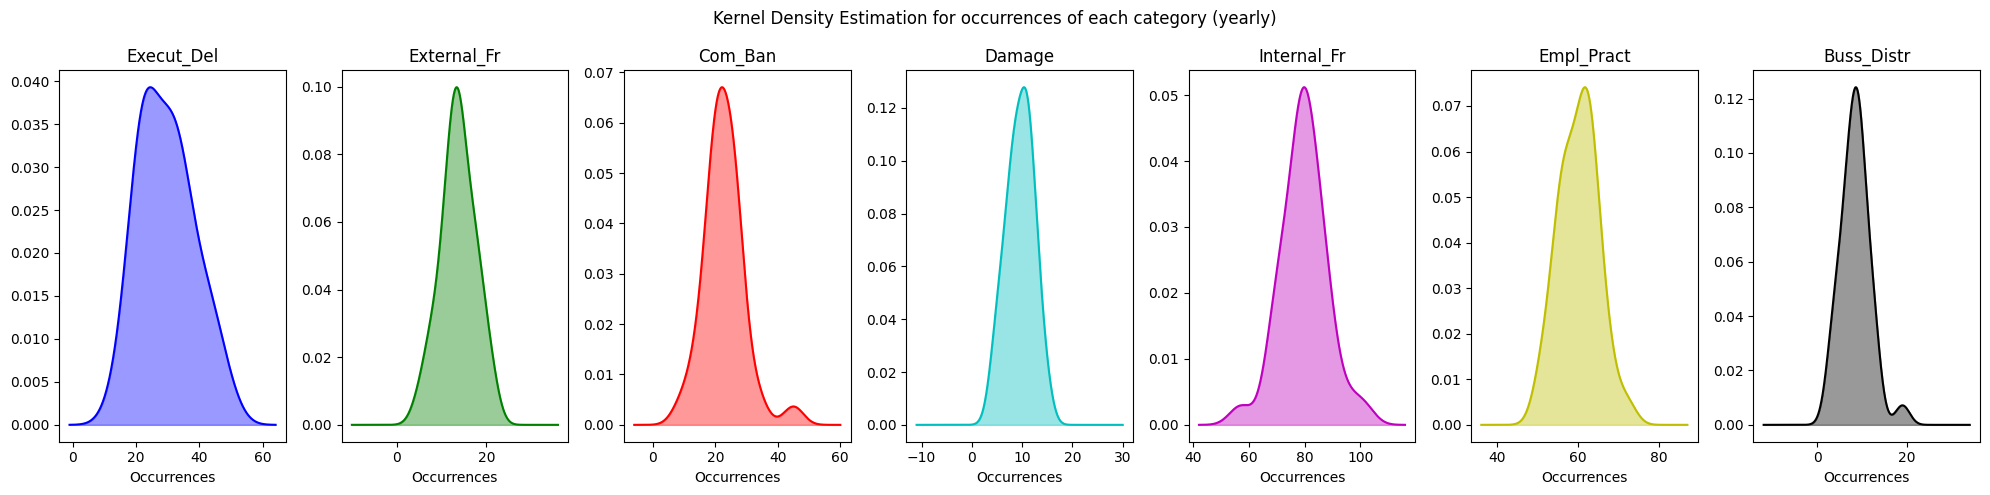

In [18]:
fig, axes = plt.subplots(ncols=len(categories), figsize=(20, 5))
fig.suptitle('Kernel Density Estimation for occurrences of each category (yearly)')

for i, category in enumerate(categories):
    kde = KernelDensity(kernel='gaussian', bandwidth=scott_rule(frequency_table.loc[category])).fit(frequency_table.loc[category].values.reshape(-1, 1))
    x = np.linspace(frequency_table.loc[category].min() - 15, frequency_table.loc[category].max() + 15, 1000)
    y = np.exp(kde.score_samples(x.reshape(-1, 1)))
    axes[i].plot(x, y, color=colors[i])
    axes[i].fill_between(x, y, alpha=0.4, color=colors[i])
    axes[i].set_title(category)
    axes[i].set_xlabel('Occurrences')

plt.tight_layout()
plt.show()

In [19]:
dist = distfit(distr=['norm', 't', 'pareto', 'gamma', 'dweibull', 'lognorm', 'uniform'])
distributions_for_years = {}

for category in categories:
    data_category = frequency_table.loc[category]
    dist.fit_transform(data_category, verbose=0)
    distributions_for_years[category] = dist.model
    print(category, ':', dist.model['name'], '\n fit :', round(dist.model['score'], 5))

Execut_Del : dweibull 
 fit : 0.00032
External_Fr : gamma 
 fit : 0.00762
Com_Ban : t 
 fit : 0.00054
Damage : t 
 fit : 0.00468
Internal_Fr : norm 
 fit : 0.00062
Empl_Pract : norm 
 fit : 0.00106
Buss_Distr : t 
 fit : 0.01187


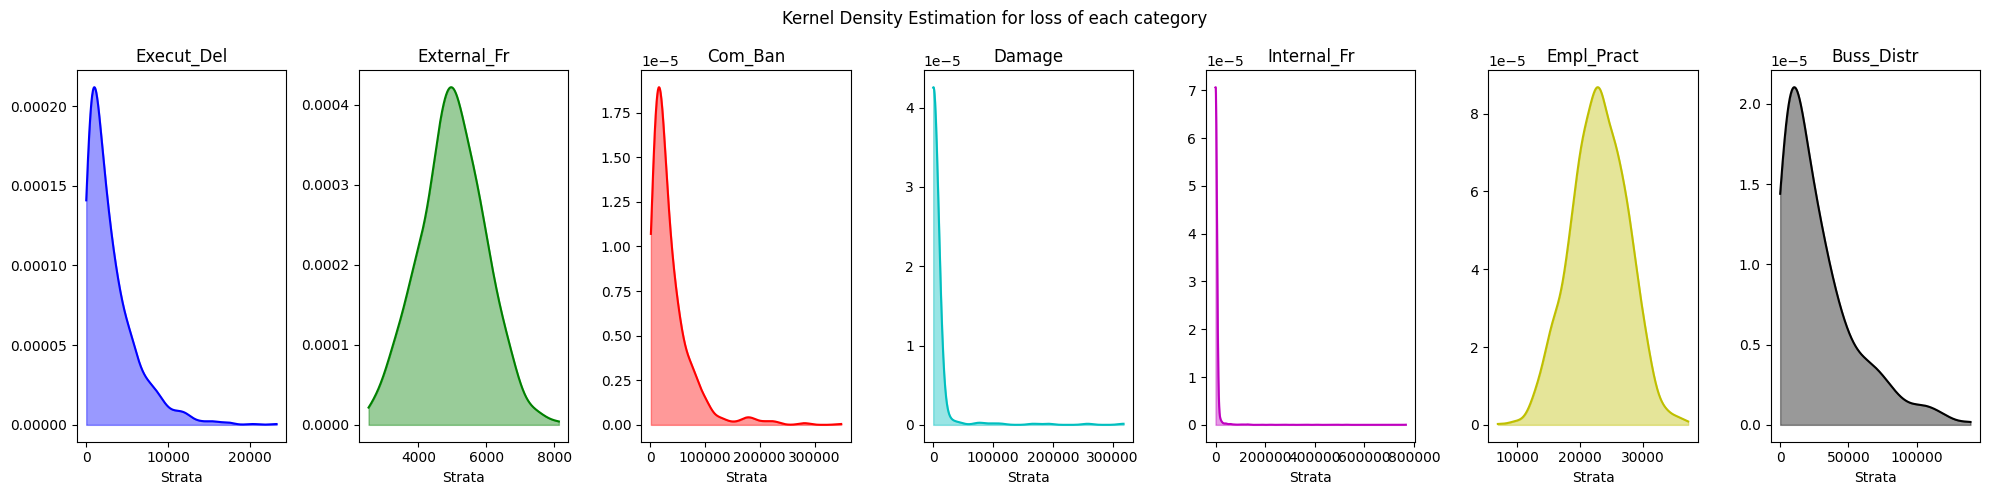

In [20]:
fig, axes = plt.subplots(ncols=len(categories), figsize=(20, 5))
fig.suptitle('Kernel Density Estimation for loss of each category')

for i, category in enumerate(categories):
    kde = KernelDensity(kernel='gaussian', bandwidth=scott_rule(data[data['linia'] == category]['strata'])).fit(data[data['linia'] == category]['strata'].values.reshape(-1, 1))
    x = np.linspace(data[data['linia'] == category]['strata'].min() - 15, data[data['linia'] == category]['strata'].max() + 15, 1000)
    y = np.exp(kde.score_samples(x.reshape(-1, 1)))
    axes[i].plot(x, y, color=colors[i])
    axes[i].fill_between(x, y, alpha=0.4, color=colors[i])
    axes[i].set_title(category)
    axes[i].set_xlabel('Strata')

plt.tight_layout()
plt.show()

In [21]:
distributions_for_losses = {}

for category in categories:
    data_category = data[data['linia'] == category]['strata'].values
    dist.fit_transform(data_category, verbose=0)
    distributions_for_losses[category] = dist.model
    print(category, ':', dist.model['name'], '\n fit :', dist.model['score'])

Execut_Del : gamma 
 fit : 8.340405859053144e-10
External_Fr : t 
 fit : 1.5467174474783796e-08
Com_Ban : t 
 fit : 2.6413289147993546e-10
Damage : pareto 
 fit : 2.0041670710609322e-05
Internal_Fr : pareto 
 fit : 8.104338725067316e-06
Empl_Pract : norm 
 fit : 3.4539809611450253e-10
Buss_Distr : gamma 
 fit : 5.9126630071757414e-12


In [22]:
def simulate_loss(n):
    losses = np.zeros(n)
    for _ in range(n):
        loss = 0
        for category in categories:
            occurrences = round(distributions_for_years[category]['model'].rvs())
            simulated_losses = distributions_for_losses[category]['model'].rvs(occurrences if occurrences > 0 else 0)
            simulated_losses = [0 if loss < 0 else loss for loss in simulated_losses] 
            loss += sum(simulated_losses)
        losses[_] = loss

    return losses

In [27]:
results = pd.DataFrame()
opVar = []
opEs = []
np.random.seed(10)
for _ in tqdm(range(30)):
    results[_] = simulate_loss(200)
    opVar.append(np.percentile(results[_], 99.9))
    opEs.append(np.mean(results[_][results[_] > opVar[-1]]))

print('opVar: \nmean: ', round(np.mean(opVar), 2), '\nstd: ', round(np.std(opVar), 2))
print('opEs: \nmean: ', round(np.mean(opEs), 2), '\nstd: ', round(np.std(opEs), 2))

100%|██████████| 30/30 [00:10<00:00,  2.81it/s]

opVar: 
mean:  17118425805690.94 
std:  90884791791830.9
opEs: 
mean:  21366602145419.8 
std:  113459050463632.05
